In [1]:
import numpy as np
import pandas as pd

# Cargo la base que ya limpiamos y exportamos en el modelo 1
df = pd.read_csv('df_cleaned.csv')

# Me aseguro de que no haya precios nulos o no positivos
df = df[df['price'] > 0].copy()

# Target en log(precio) para estabilizar la varianza
df['log_price'] = np.log(df['price'])

# Tomo solo columnas numéricas (incluye dummies 0/1)
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Quito la columna de precio original y el log_price del set de features
numeric_cols.remove('price')
numeric_cols.remove('log_price')

# Matrices finales para el modelo
X = df[numeric_cols].values
y = df['log_price'].values

print("Shape X:", X.shape)
print("Shape y:", y.shape)
print("Número de features:", len(numeric_cols))


Shape X: (20827, 98)
Shape y: (20827,)
Número de features: 98


In [2]:
from sklearn.model_selection import train_test_split

# Parto en train y test (dejo 20% para test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train:", X_train.shape, y_train.shape)
print("Test :", X_test.shape, y_test.shape)

# Importo TensorFlow (igual que en el taller)
import setuptools.dist  # parche para Python 3.12
import tensorflow as tf

# Normalización sobre los datos de entrenamiento
normalizer = tf.keras.layers.Normalization()
normalizer.adapt(X_train)

n_features = X_train.shape[1]
print("Features que ve la red:", n_features)


Train: (16661, 98) (16661,)
Test : (4166, 98) (4166,)
Features que ve la red: 98


In [3]:
# Función que arma un MLP dado un set de hiperparámetros
def build_mlp(hidden_units, activation='relu',
              dropout_rate=0.0, learning_rate=1e-3):
    """
    hidden_units: lista con las neuronas por capa oculta, ej. [128, 64]
    activation: función de activación para todas las capas ocultas
    dropout_rate: tasa de dropout después de cada capa (0 si no quiero)
    learning_rate: lr del optimizador Adam
    """
    model = tf.keras.Sequential()
    
    # Entrada + normalización
    model.add(tf.keras.Input(shape=(n_features,)))
    model.add(normalizer)
    
    # Capas densas ocultas
    for units in hidden_units:
        model.add(tf.keras.layers.Dense(units, activation=activation))
        if dropout_rate > 0:
            model.add(tf.keras.layers.Dropout(dropout_rate))
    
    # Capa de salida: una neurona, regresión en log(price)
    model.add(tf.keras.layers.Dense(1))
    
    # Compilo usando MSE en log(price); reporto RMSE y MAE
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='mse',
        metrics=[
            tf.keras.metrics.RootMeanSquaredError(name='rmse'),
            tf.keras.metrics.MeanAbsoluteError(name='mae')
        ]
    )
    
    return model

# Callback de early stopping para no entrenar de más
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 98)             │           197 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        12,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,190 (82.78 KB)

 Trainable params: 20,993 (82.00 KB)

 Non-trainable params: 197 (792.00 B)

Epoch 1/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 8.1313 - mae: 2.1094 - rmse: 2.8515 - val_loss: 1.6401 - val_mae: 0.9330 - val_rmse: 1.2807
Epoch 2/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.1030 - mae: 0.9939 - rmse: 1.4502 - val_loss: 0.6128 - val_mae: 0.5515 - val_rmse: 0.7828
Epoch 3/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.4486 - mae: 0.8849 - rmse: 1.2036 - val_loss: 0.4144 - val_mae: 0.4609 - val_rmse: 0.6437
Epoch 4/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1710 - mae: 0.8196 - rmse: 1.0821 - val_loss: 0.3826 - val_mae: 0.4419 - val_rmse: 0.6185
Epoch 5/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1135 - mae: 0.7909 - rmse: 1.0552 - val_loss: 0.3616 - val_mae: 0.4266 - val_rmse: 0.6014
Epoch 6/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0499 - mae: 0.7570 - rmse: 1.0246 - val_loss: 0.3189 - val_mae: 0.3976 - val_rmse: 0.5647
Epoch 7/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9118 - mae: 0.7262 - rmse: 0.9549

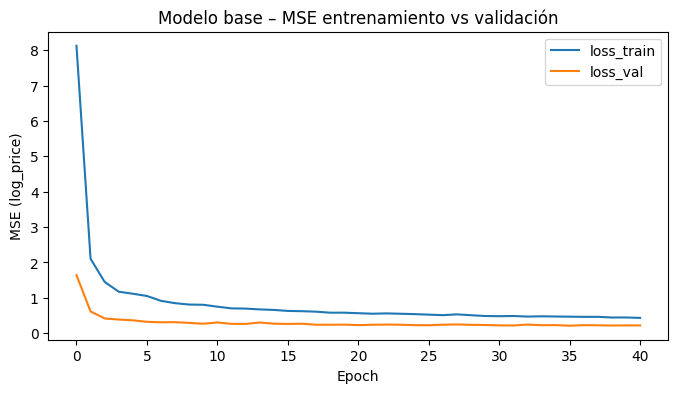

Modelo base – loss, rmse_log, mae_log: [4498255360.0, 67069.03125, 1991.5382080078125]


In [4]:
import matplotlib.pyplot as plt

# Arquitectura base: 2 capas ocultas con 128 y 64 neuronas
base_hidden = [128, 64]

model_base = build_mlp(
    hidden_units=base_hidden,
    activation='relu',
    dropout_rate=0.2,
    learning_rate=1e-3
)

model_base.summary()

# Entrenamiento del modelo base
history_base = model_base.fit(
    X_train,
    y_train,
    validation_split=0.2,  # guardo un 20% del train para validación
    epochs=100,
    batch_size=256,
    callbacks=[early_stop],
    verbose=1
)

# Convierto el history a DataFrame para revisar
hist_base = pd.DataFrame(history_base.history)
hist_base['epoch'] = history_base.epoch
hist_base.head()

# Curvas de entrenamiento vs validación
plt.figure(figsize=(8, 4))
plt.plot(hist_base['epoch'], hist_base['loss'], label='loss_train')
plt.plot(hist_base['epoch'], hist_base['val_loss'], label='loss_val')
plt.xlabel('Epoch')
plt.ylabel('MSE (log_price)')
plt.legend()
plt.title('Modelo base – MSE entrenamiento vs validación')
plt.show()

# Métricas en test para tener la línea base
eval_base = model_base.evaluate(X_test, y_test, verbose=0)
print("Modelo base – loss, rmse_log, mae_log:", eval_base)
